In [1]:
import json
import warnings
from pathlib import Path

import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
import plotly.io as pio
from shapely.geometry import Polygon

In [2]:
# --- Configurações do Pandas ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- Configurações de Avisos ---
# Ignora avisos de depreciação comuns em libs geoespaciais
warnings.filterwarnings('ignore')

# --- Configurações do Plotly ---
pio.templates.default = "plotly_white"
pio.templates[pio.templates.default].layout.font = dict(
    family="Arial, sans-serif",
    size=16,
    color="black"
)

# --- Definição de Caminhos (Pathlib) ---
DATA_DIR = Path(".") # Diretório atual
GATEWAYS_FILE = DATA_DIR / 'lorawan_antwerp_gateway_locations.json'
CONFIG_FILE = DATA_DIR / 'config.json'
OUTPUT_DIR = DATA_DIR / "imagens"

# Criação do diretório de saída se não existir
if not OUTPUT_DIR.exists():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Diretório criado: {OUTPUT_DIR}")
else:
    print(f"Diretório de saída: {OUTPUT_DIR}")

Diretório de saída: imagens


In [3]:
def carregar_dados_geo(gateways_path, config_path):
    """
    Carrega dados dos gateways e configuração de limites (bounds),
    retornando um DataFrame processado e o GeoJSON da área de interesse.
    """
    try:
        # 1. Carregar Gateways
        if not gateways_path.exists():
            raise FileNotFoundError(f"Arquivo não encontrado: {gateways_path}")
            
        with open(gateways_path, 'r') as f:
            gateways_data = json.load(f)
        
        # Transforma em DataFrame e renomeia índice para coluna
        df = pd.DataFrame.from_dict(gateways_data, orient='index')
        df = df.reset_index().rename(columns={'index': 'gateway_id'})
        
        # 2. Carregar Configuração e Criar Polígono
        if not config_path.exists():
            raise FileNotFoundError(f"Arquivo não encontrado: {config_path}")
            
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        bounds = config.get('bounds')
        if not bounds:
            raise ValueError("Chave 'bounds' não encontrada no config.json")

        # Criação do Polígono (Shapely)
        poly = Polygon([
            (bounds['min_lon'], bounds['min_lat']),
            (bounds['min_lon'], bounds['max_lat']),
            (bounds['max_lon'], bounds['max_lat']),
            (bounds['max_lon'], bounds['min_lat']),
        ])
        
        # Criação do GeoDataFrame e conversão para GeoJSON (Interface __geo_interface__)
        gdf_bounds = gpd.GeoDataFrame(geometry=[poly], crs="EPSG:4326")
        geojson_bounds = gdf_bounds.__geo_interface__
        
        print(f"Dados carregados. Gateways: {len(df)}")
        return df, geojson_bounds, bounds

    except Exception as e:
        print(f"Erro no processamento de dados: {e}")
        return None, None, None

# Execução do carregamento
df_gateways, geojson_area, bounds_dict = carregar_dados_geo(GATEWAYS_FILE, CONFIG_FILE)

if df_gateways is not None:
    display(df_gateways.head())

Dados carregados. Gateways: 249


,gateway_id,latitude,longitude
0,FF010F35,50.898949,4.437971
1,FF0107C9,51.219257,4.413227
2,FF010684,51.031765,3.752673
3,FF010EE1,51.024288,4.172601
4,FF0178F5,51.120323,5.266541


Gerando mapa interativo...
Mapa salvo com sucesso em: imagens/mapa_gateways.png


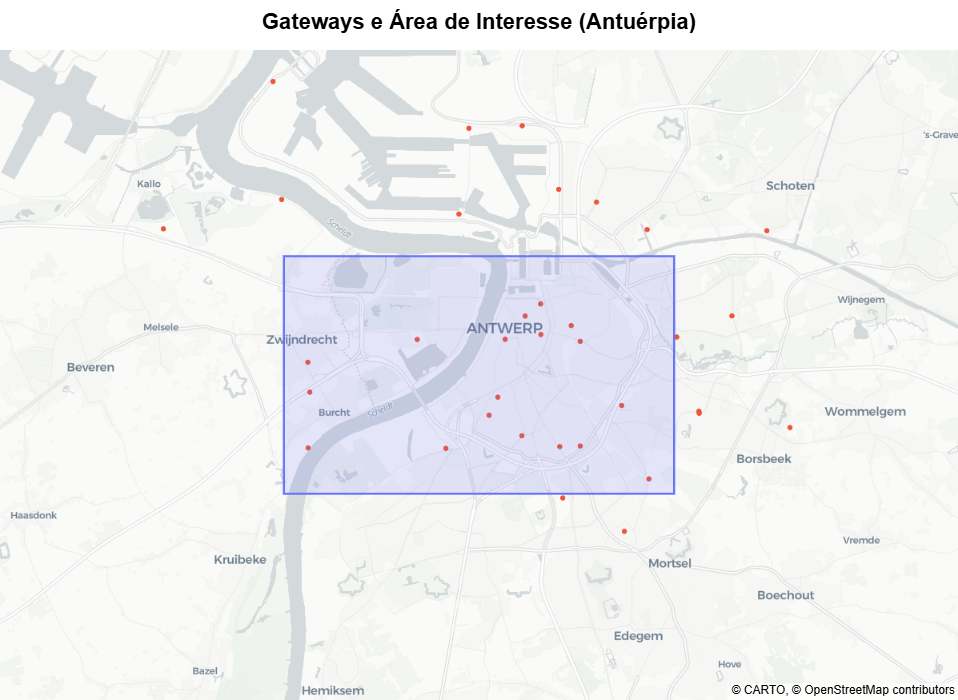

In [4]:
def plotar_mapa_gateways(df, geojson_poly, bounds, nome_arquivo="mapa_gateways.png"):
    """
    Gera mapa interativo dos gateways com a área de interesse delimitada.
    Salva em PNG de alta qualidade (sem título) e exibe com título.
    """
    if df is None or geojson_poly is None:
        print("Dados insuficientes para plotagem.")
        return

    # Calcula o centro do mapa dinamicamente
    lat_center = np.mean([bounds['min_lat'], bounds['max_lat']])
    lon_center = np.mean([bounds['min_lon'], bounds['max_lon']])

    print("Gerando mapa interativo...")
    
    fig = px.scatter_map(
        df,
        lat="latitude",
        lon="longitude",
        hover_name="gateway_id",
        color_discrete_sequence=["#EF553B"], # Vermelho vibrante
        zoom=11,
        center={"lat": lat_center, "lon": lon_center}
    )

    # Configuração Avançada do Layout de Mapa
    fig.update_layout(
        map_style="carto-positron",
        height=700,
        margin={"r":0,"t":50,"l":0,"b":0}, # Margens ajustadas
        # Adiciona as camadas do polígono (Área de Interesse)
        map_layers=[
            {
                "source": geojson_poly,
                "type": "fill",
                "color": "#636EFA", # Azul Plotly
                "opacity": 0.15
            },
            {
                "source": geojson_poly,
                "type": "line",
                "color": "#636EFA",
                "line": {"width": 2}
            }
        ]
    )

    # --- Fluxo de Salvamento (Clean Code) ---
    caminho_saida = OUTPUT_DIR / nome_arquivo
    
    # 1. Garantir que não há título para o arquivo salvo (requisito profissional)
    fig.update_layout(title_text=None)
    
    # 2. Salvar em Alta Resolução (scale=3 equivale a ~300 DPI)
    try:
        fig.write_image(caminho_saida, scale=3, width=1200, height=800)
        print(f"Mapa salvo com sucesso em: {caminho_saida}")
    except Exception as e:
        print(f"Erro ao salvar imagem (verifique se o pacote kaleido está instalado): {e}")

    # 3. Adicionar título para visualização no Notebook e exibir
    fig.update_layout(
        title={
            'text': "<b>Gateways e Área de Interesse (Antuérpia)</b>",
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )
    fig.show()

# Execução
plotar_mapa_gateways(df_gateways, geojson_area, bounds_dict)